<h2>LSTM on Donors Choose Dataset

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from IPython.display import Image
from scipy import sparse

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from keras.layers import Conv1D
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras import regularizers
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tqdm import tqdm
import os
import datetime
import chart_studio.plotly as py
#from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

Using TensorFlow backend.


In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

<h3> Data Preprocessing

In [3]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()

In [4]:
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()

In [5]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()

In [6]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna('Mrs.')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()

In [7]:
project_data['school_state'] = project_data['school_state'].str.lower()

In [8]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [10]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [11]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [12]:
preprocessed_essays = preprocess_text(project_data['essay'].values)
project_data['preprocessed_essays'] = preprocessed_essays

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [00:59<00:00, 1849.45it/s]


In [13]:
preprocessed_titles = preprocess_text(project_data['project_title'].values)
project_data['preprocessed_titles'] = preprocessed_titles

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:02<00:00, 38133.56it/s]


In [14]:
project_data['text'] = project_data['preprocessed_essays'].map(str) + ' ' + project_data['preprocessed_titles'].map(str) 

In [15]:
summary_numerical = []
for i in project_data['project_resource_summary']:
    j = ' '.join(word for word in i.split() if word.isdigit())
    k=len(j)
    summary_numerical.append(k)

project_data["summary_numerical"] = summary_numerical

In [16]:
project_data.drop(['Unnamed: 0','teacher_id','project_submitted_datetime','project_essay_1','project_essay_2',\
                   'project_essay_3','project_essay_4','essay','preprocessed_essays','preprocessed_titles','project_title','project_resource_summary'], axis=1, inplace=True)
resource_data.drop(['description'], axis=1, inplace=True)
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
preprocessed_data = pd.merge(project_data, price_data,on='id', how='left')
preprocessed_data.drop(['id'], axis=1, inplace=True)
print(preprocessed_data.columns)

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'text', 'summary_numerical', 'price', 'quantity'],
      dtype='object')


In [17]:
preprocessed_data.head(2)

teacher_prefix school_state project_grade_category  \
0            mrs           in          grades_prek_2   
1             mr           fl             grades_6_8   

     project_subject_categories project_subject_subcategories  \
0             literacy_language                  esl_literacy   
1  history_civics_health_sports  civics_government_teamsports   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

                                                text  summary_numerical  \
0  students english learners working english seco...                  0   
1  students arrive school eager learn polite gene...                  0   

   price  quantity  
0  154.6        23  
1  299.0         1

In [18]:
preprocessed_data.to_csv('preprocessed_data.csv')

In [5]:
preprocessed_data = pd.read_csv('preprocessed_data.csv')

In [6]:
X_data = preprocessed_data.drop(['project_is_approved'], axis=1)
y_data = preprocessed_data['project_is_approved']

<h3>Data Splitting

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, stratify=y_data)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(76473, 11) (76473,) (32775, 11) (32775,)


In [8]:
x_train.head(2)

Unnamed: 0 teacher_prefix school_state project_grade_category  \
7136         7136            mrs           nc             grades_3_5   
54781       54781             mr           al             grades_6_8   

           project_subject_categories project_subject_subcategories  \
7136   literacy_language_math_science          literacy_mathematics   
54781  literacy_language_specialneeds         literacy_specialneeds   

       teacher_number_of_previously_posted_projects  \
7136                                              0   
54781                                             3   

                                                    text  summary_numerical  \
7136   students eager learn take advantage education ...                  0   
54781  school k 8 title school 100 students receive f...                  0   

        price  quantity  
7136   314.97         3  
54781  330.77         5

<h2>Assignment-1

<h3>Vectorizing Text data

Reference : https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['text'].values)
vocab_size = len(tokenizer.word_index) + 1
text_train = tokenizer.texts_to_sequences(x_train['text'].values)
text_test = tokenizer.texts_to_sequences(x_test['text'].values)

print(len(text_train))
print(text_train[1])

76473
[1, 680, 3484, 1548, 2, 25, 66, 733, 162, 31, 80, 172, 107, 8, 31, 80, 172, 107, 1548, 1993, 2, 25, 16, 66, 159, 5, 33, 33, 108, 18, 94, 327, 31, 8, 1, 17, 121, 454, 402, 56, 288, 76, 723, 23, 96, 222, 1, 3621, 8, 917, 599, 99, 40, 88, 118, 51, 279, 1, 6887, 361, 10639, 631, 1505, 205, 88, 203, 505, 88, 196, 1, 362, 174, 11236, 1793, 4, 71, 1652, 204, 89, 285, 1576, 828, 196, 88, 71, 2713, 30, 109, 1, 298, 28, 255, 1, 5, 151, 44, 698, 138, 71, 1, 16, 255, 62, 624, 334, 913, 828, 196, 86, 375, 913, 9, 79, 88, 1639, 4]


In [24]:
max_length_1 = 500
x_text_train = sequence.pad_sequences(text_train, maxlen=max_length_1, padding='post')
x_text_test = sequence.pad_sequences(text_test, maxlen=max_length_1, padding='post')

print(len(x_text_train))
print(x_text_train[1])

76473
[    1   680  3484  1548     2    25    66   733   162    31    80   172
   107     8    31    80   172   107  1548  1993     2    25    16    66
   159     5    33    33   108    18    94   327    31     8     1    17
   121   454   402    56   288    76   723    23    96   222     1  3621
     8   917   599    99    40    88   118    51   279     1  6887   361
 10639   631  1505   205    88   203   505    88   196     1   362   174
 11236  1793     4    71  1652   204    89   285  1576   828   196    88
    71  2713    30   109     1   298    28   255     1     5   151    44
   698   138    71     1    16   255    62   624   334   913   828   196
    86   375   913     9    79    88  1639     4     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0   

In [25]:
# weight matrix using glove vectors 
with open("glove_vectors", "rb") as fp: # Unpickling
    glove_vectors = pickle.load(fp)
    
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(51045, 300)

<h3>Encoding Categorical data

In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['school_state'].values)
vocab_size_state = len(tokenizer.word_index) + 1
x_state_train = tokenizer.texts_to_sequences(x_train['school_state'].values)
x_state_test = tokenizer.texts_to_sequences(x_test['school_state'].values)

In [46]:
x_state_train = sequence.pad_sequences(x_state_train, maxlen=2, padding='post')
x_state_test = sequence.pad_sequences(x_state_test, maxlen=2, padding='post')

In [47]:
print(len(x_state_train))
print(x_state_train[1])

76473
[1 0]


In [48]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['teacher_prefix'].values)
vocab_size_prefix = len(tokenizer.word_index) + 1
x_prefix_train = tokenizer.texts_to_sequences(x_train['teacher_prefix'].values)
x_prefix_test = tokenizer.texts_to_sequences(x_test['teacher_prefix'].values)

In [49]:
x_prefix_train = sequence.pad_sequences(x_prefix_train, maxlen=2, padding='post')
x_prefix_test = sequence.pad_sequences(x_prefix_test, maxlen=2, padding='post')

In [50]:
print(len(x_prefix_train))
print(x_prefix_train[1])

76473
[1 0]


In [51]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['project_grade_category'].values)
vocab_size_grade = len(tokenizer.word_index) + 1
x_grade_train = tokenizer.texts_to_sequences(x_train['project_grade_category'].values)
x_grade_test = tokenizer.texts_to_sequences(x_test['project_grade_category'].values)

In [52]:
x_grade_train = sequence.pad_sequences(x_grade_train, maxlen=5, padding='post')
x_grade_test = sequence.pad_sequences(x_grade_test, maxlen=5, padding='post')

print(len(x_grade_train))
print(x_grade_train[1])

76473
[1 8 9 0 0]


In [53]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['project_subject_categories'].values)
vocab_size_categories = len(tokenizer.word_index) + 1
x_categories_train = tokenizer.texts_to_sequences(x_train['project_subject_categories'].values)
x_categories_test = tokenizer.texts_to_sequences(x_test['project_subject_categories'].values)

In [54]:
x_categories_train = sequence.pad_sequences(x_categories_train, maxlen=5, padding='post')
x_categories_test = sequence.pad_sequences(x_categories_test, maxlen=5, padding='post')

print(len(x_categories_train))
print(x_categories_train[1])

76473
[ 3  4  9 10  0]


In [55]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['project_subject_subcategories'].values)
vocab_size_subcategories = len(tokenizer.word_index) + 1
x_subcategories_train = tokenizer.texts_to_sequences(x_train['project_subject_subcategories'].values)
x_subcategories_test = tokenizer.texts_to_sequences(x_test['project_subject_subcategories'].values)

In [56]:
x_subcategories_train = sequence.pad_sequences(x_subcategories_train, maxlen=5, padding='post')
x_subcategories_test = sequence.pad_sequences(x_subcategories_test, maxlen=5, padding='post')

print(len(x_subcategories_train))
print(x_subcategories_train[1])

76473
[7 9 0 0 0]


<h3>Standardizing Numerical data

In [10]:
scaler = StandardScaler()
x_quantity_train = scaler.fit_transform(x_train['quantity'].values.reshape(-1,1))
x_quantity_test = scaler.transform(x_test['quantity'].values.reshape(-1,1))

In [11]:
scaler = StandardScaler()
x_price_train = scaler.fit_transform(x_train['price'].values.reshape(-1,1))
x_price_test = scaler.transform(x_test['price'].values.reshape(-1,1))

In [12]:
scaler = StandardScaler()
x_no_projects_train = scaler.fit_transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_no_projects_test = scaler.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [13]:
scaler = StandardScaler()
x_summary_numerical_train = scaler.fit_transform(x_train['summary_numerical'].values.reshape(-1,1))
x_summary_numerical_test = scaler.transform(x_test['summary_numerical'].values.reshape(-1,1))

In [23]:
x_numerical_train = np.concatenate((x_quantity_train,x_price_train,x_no_projects_train,x_summary_numerical_train), axis=1)
x_numerical_test = np.concatenate((x_quantity_test,x_price_test,x_no_projects_test,x_summary_numerical_test), axis=1)

In [25]:
x_numerical_train.shape

(76473, 4)

<h3>Encoding Y_data

In [26]:
y_train = keras.utils.to_categorical(y_train,num_classes= 2)
y_test = keras.utils.to_categorical(y_test,num_classes= 2)

<h3>Function for AUC

Reference : https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/80807

In [38]:
def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

<h3>Model 1

In [47]:
input_text = Input(shape=(500,), dtype='int32', name = "text_sequence")
embedding_text = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix],input_length=max_length_1, \
                           trainable=False)(input_text)
lstm_text  = LSTM(16, activation="relu", return_sequences=True)(embedding_text)
flatten_text = Flatten()(lstm_text)

Instructions for updating:
Colocations handled automatically by placer.


In [48]:
input_school_state = Input(shape=(2,), dtype='int32', name = "school_state")
embedding_school_state = Embedding(input_dim=vocab_size_state, output_dim=8, trainable=True)(input_school_state)
flatten_school_state = Flatten()(embedding_school_state)

In [49]:
input_teacher_prefix = Input(shape=(2,), dtype='int32', name = "teacher_prefix")
embedding_teacher_prefix = Embedding(input_dim=vocab_size_prefix, output_dim=8, trainable=True)(input_teacher_prefix)
flatten_teacher_prefix = Flatten()(embedding_teacher_prefix)

In [50]:
input_project_grade = Input(shape=(5,), dtype='int32', name = "project_grade")
embedding_project_grade = Embedding(input_dim=vocab_size_grade, output_dim=8,input_length=5, trainable=True)\
                            (input_project_grade)
flatten_project_grade = Flatten()(embedding_project_grade)

In [51]:
input_categories = Input(shape=(5,), dtype='int32', name = "categories")
embedding_categories = Embedding(input_dim=vocab_size_categories, output_dim=8,input_length=5, trainable=True)\
                                (input_categories)
flatten_categories = Flatten()(embedding_categories)

In [52]:
input_sub_categories = Input(shape=(5,), dtype='int32', name = "sub_categories")
embedding_sub_categories= Embedding(input_dim=vocab_size_subcategories, output_dim=8,input_length=5, trainable=True)\
                            (input_sub_categories)
flatten_sub_categories = Flatten()(embedding_sub_categories)

In [53]:
input_numerical = Input(shape=(4,),name="numerical_sequence")
dense_numerical = Dense(100,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))\
                    (input_numerical)

In [55]:
x = concatenate([flatten_text,flatten_school_state,flatten_teacher_prefix,flatten_project_grade,flatten_categories,\
                 flatten_sub_categories,dense_numerical])
x = Dense(128,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(256,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
output = Dense(2, activation='softmax', name='output')(x)
model_1 = Model(inputs=[input_text,input_school_state,input_teacher_prefix,input_project_grade,input_categories,\
                        input_sub_categories,input_numerical],outputs=[output])

In [56]:
model_1.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[auc])
model_1.summary()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_sequence (InputLayer)      (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 300)     15313500    text_sequence[0][0]              
______________________________________________________

In [57]:
train_model_1 = [x_text_train,x_state_train,x_prefix_train,x_grade_train,x_categories_train,x_subcategories_train, x_numerical_train]
test_model_1 = [x_text_test,x_state_test,x_prefix_test,x_grade_test,x_categories_test,x_subcategories_test,x_numerical_test]

<h3>Callback,Early stopping and checkpoint

Reference : https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In [66]:
checkpoint_1 = keras.callbacks.ModelCheckpoint('model_1.hdf5', save_best_only= True, monitor='val_auc', mode = 'max', verbose= 1)
early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', mode= 'max', verbose=1, patience=3)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=0)

In [67]:
history_1 = model_1.fit(train_model_1,y_train,batch_size=512,epochs=15,verbose=2,validation_data=(test_model_1,y_test),\
                        callbacks=[checkpoint_1,early_stop,tensorboard_callback])

Train on 76473 samples, validate on 32775 samples
Epoch 1/15
 - 276s - loss: 0.4620 - auc: 0.7653 - val_loss: 0.4446 - val_auc: 0.7726

Epoch 00001: val_auc improved from -inf to 0.77263, saving model to model_1.hdf5
Epoch 2/15
 - 279s - loss: 0.4320 - auc: 0.7739 - val_loss: 0.4242 - val_auc: 0.7726

Epoch 00002: val_auc did not improve from 0.77263
Epoch 3/15
 - 279s - loss: 0.4142 - auc: 0.7790 - val_loss: 0.4152 - val_auc: 0.7706

Epoch 00003: val_auc did not improve from 0.77263
Epoch 4/15
 - 282s - loss: 0.4017 - auc: 0.7865 - val_loss: 0.4101 - val_auc: 0.7710

Epoch 00004: val_auc did not improve from 0.77263
Epoch 00004: early stopping


In [68]:
best_model = load_model('model_1.hdf5', custom_objects={'auc': auc}) #retrieving best model

In [72]:
result = best_model.evaluate(test_model_1, y_test,batch_size=512) #Evaluating test_data

32775/32775 [==============================] - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 45 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 34 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 51s 2ms/step


In [3]:
%load_ext tensorboard.notebook
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 8288.

In [4]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir logs (started 0:01:17 ago; pid 7508)


<h4>Plot Train AUC vs Epochs

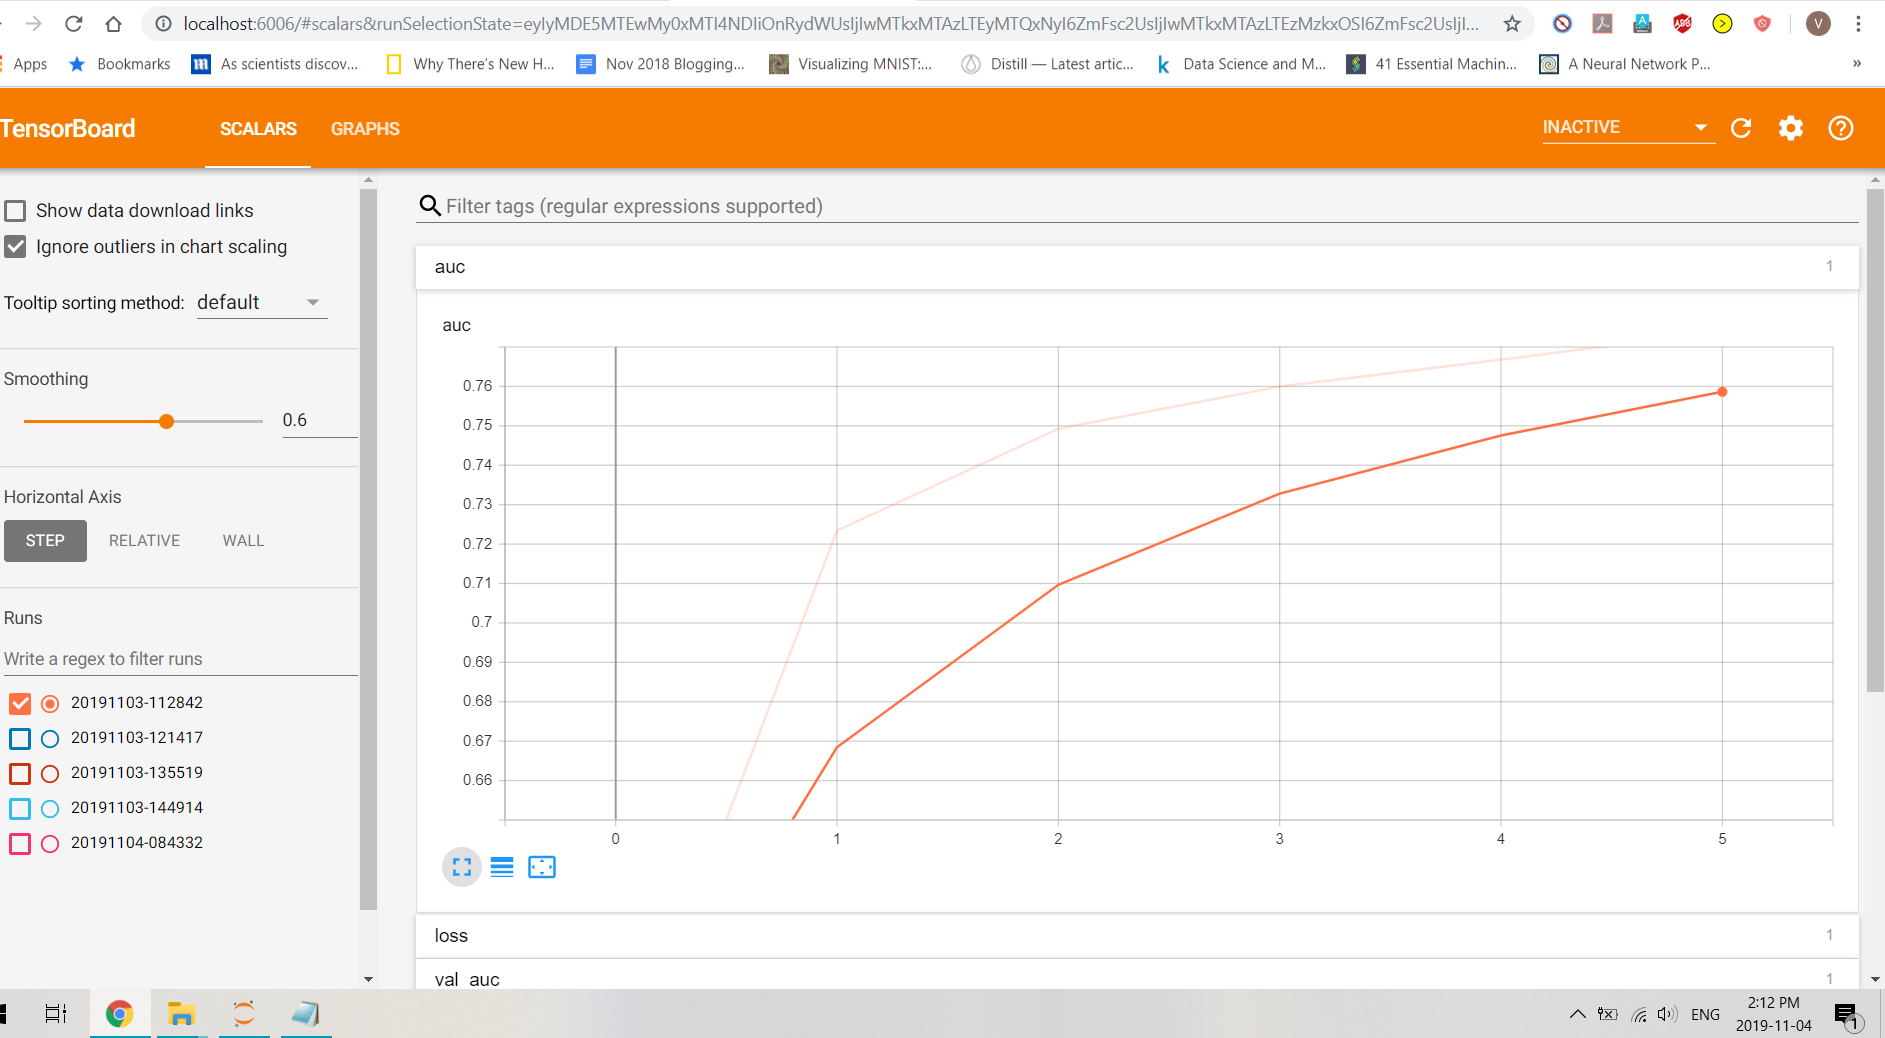

In [11]:
Image(filename='img/model_1_auc.png', width=500, height=500)

<h4>Plot : Test AUC vs Epochs

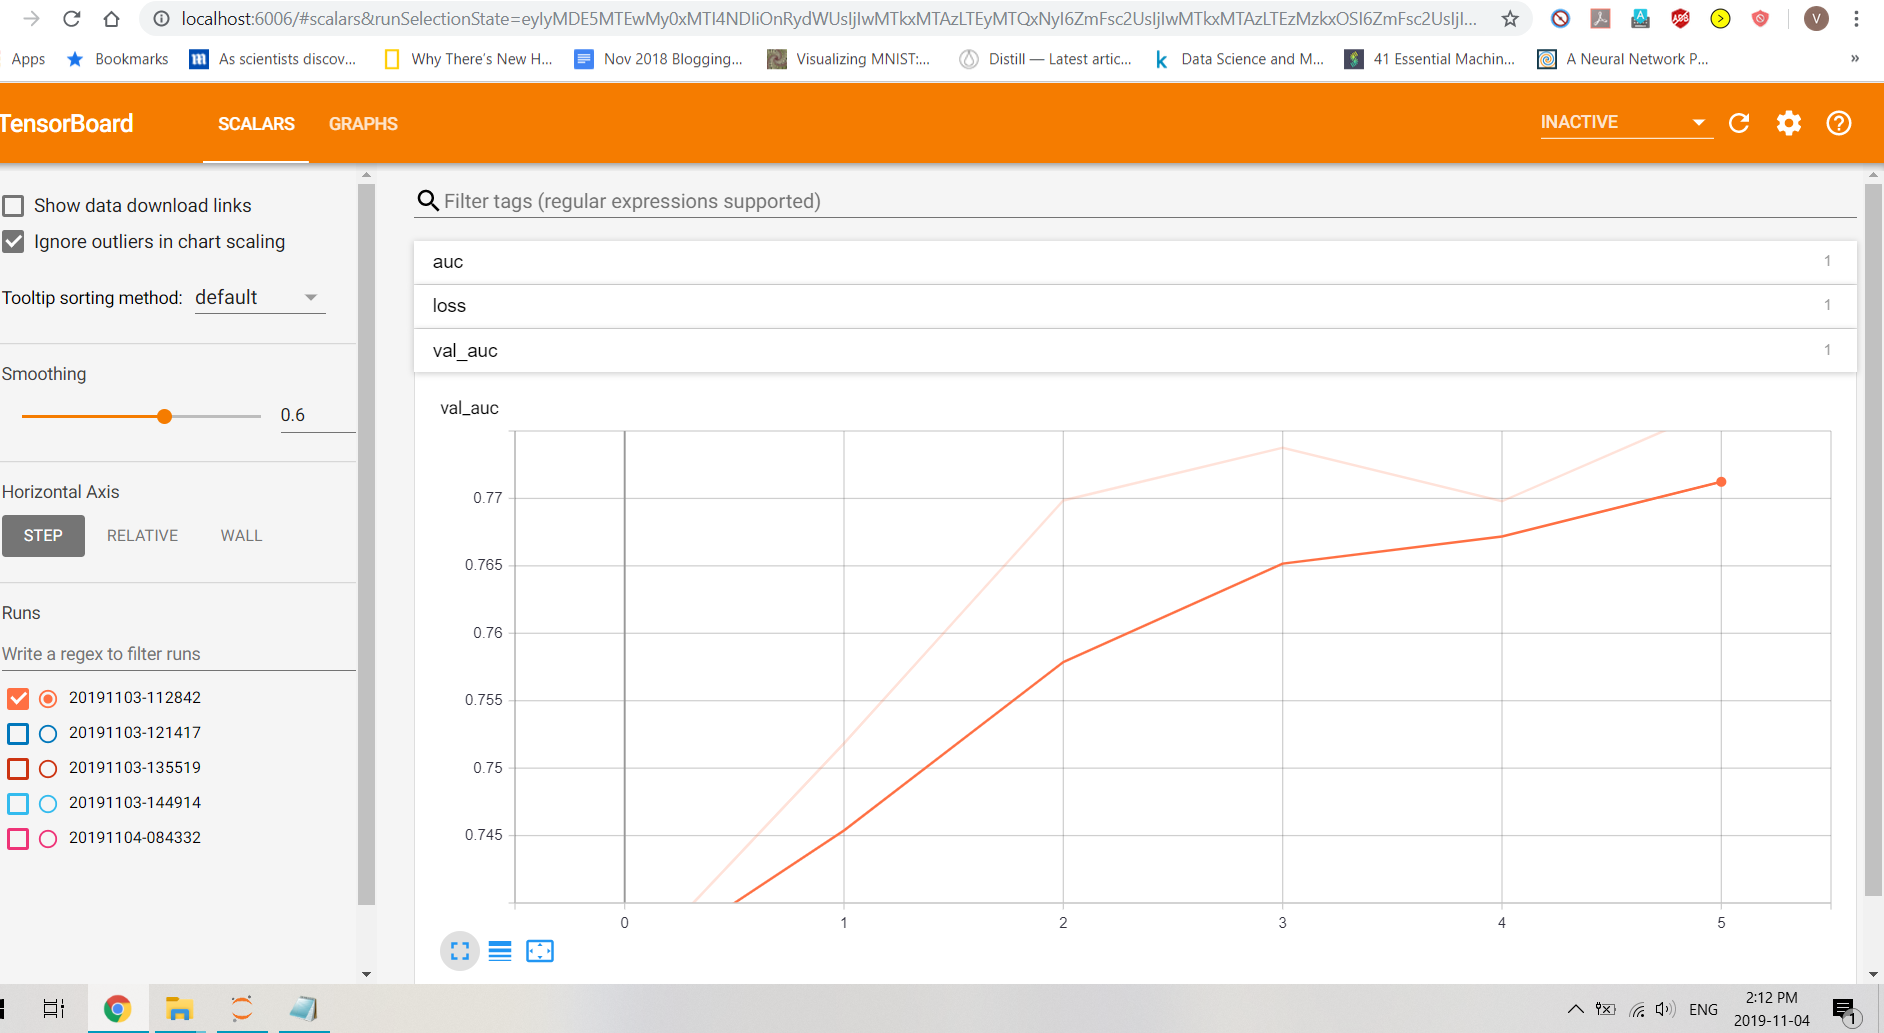

In [12]:
Image(filename='img/model_1_val_auc.png', width=500, height=500)

Reference : https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/

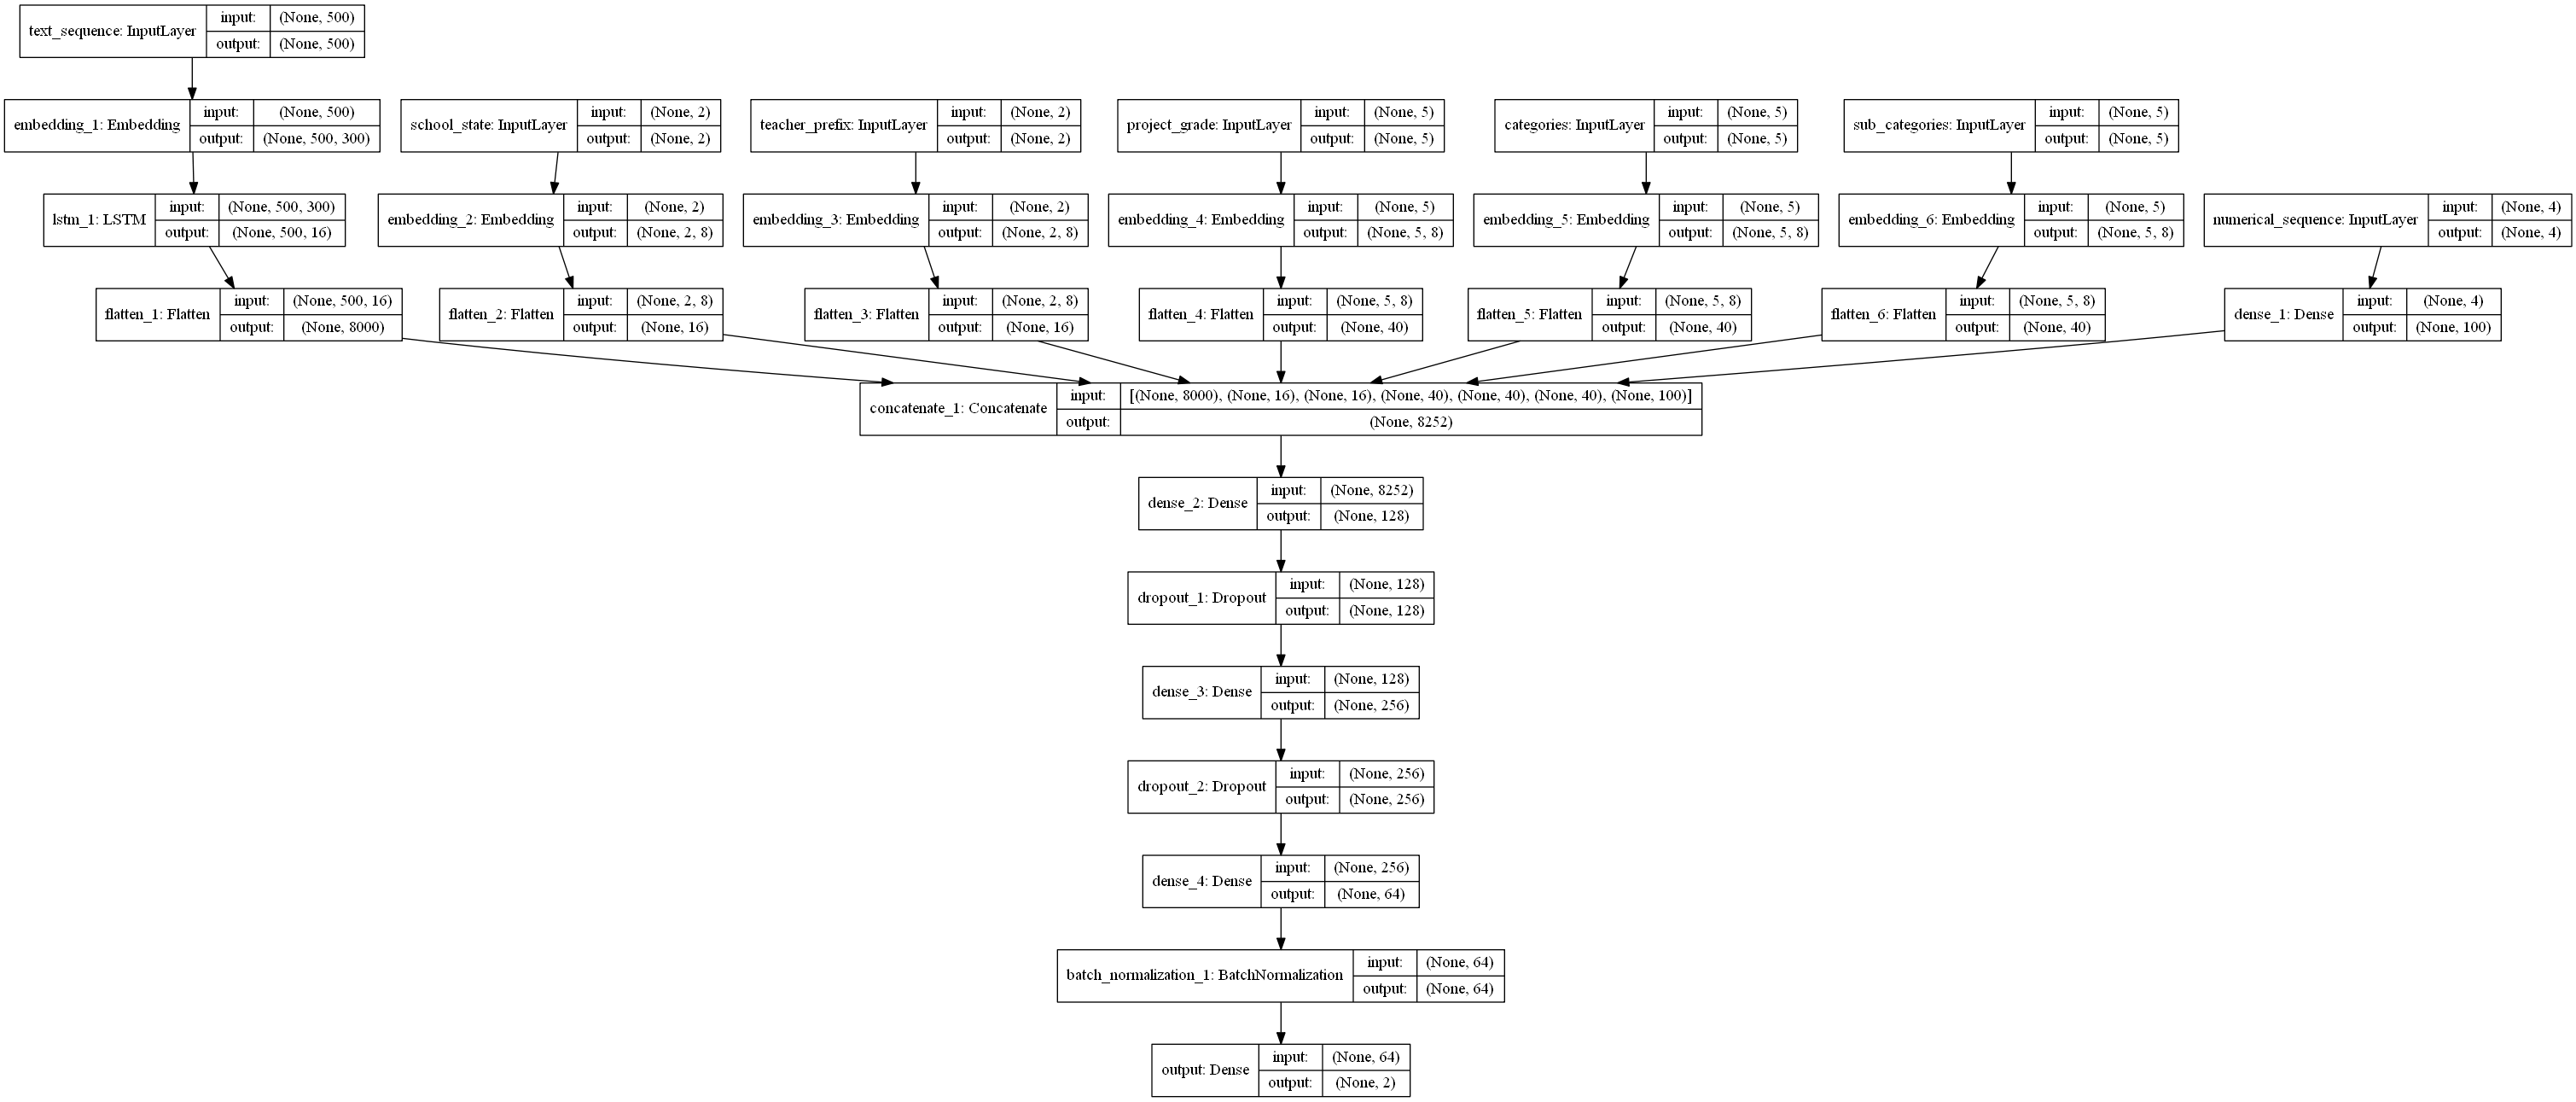

In [75]:
#displaying the model
from keras.utils.vis_utils import plot_model
plot_model(model_1, to_file='model_1.png', show_shapes=True, show_layer_names=True)

<h2>Assignment-2

<h3>TFIDF vectorization of text data

In [28]:
tfidf = TfidfVectorizer()
tfidf_text = tfidf.fit_transform(x_train['text'])

dict_text = dict(zip(tfidf.get_feature_names(),tfidf.idf_))

df_text = pd.DataFrame(list(dict_text.items()), columns=['Words', 'IDF Values'])
df_text = df_text.sort_values(by ='IDF Values' )

In [31]:
docs = df_text[(df_text['IDF Values'] >= df_text['IDF Values'].min()) & (df_text['IDF Values'] <= df_text['IDF Values'].max() )]
corpus = docs["Words"].tolist()

In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
vocab_size = len(tokenizer.word_index) + 1
text_train = tokenizer.texts_to_sequences(x_train['text'].values)
text_test = tokenizer.texts_to_sequences(x_test['text'].values)

print(len(text_train))
print(text_train[1])

76473
[1, 870, 662, 299, 48, 67, 104, 380, 837, 160, 498, 9, 1461, 1287, 61, 142, 287, 1461, 481, 63, 95, 397, 459, 255, 1213, 100, 312, 39, 475, 1, 81, 173, 420, 411, 7, 56, 269, 460, 346, 2011, 39, 5131, 59, 45, 1543, 110, 316, 22, 6336, 1061, 1110, 249, 5, 249, 640, 2179, 249, 1203, 227, 5, 25, 347, 1, 738, 249, 4, 254, 126, 1, 448, 307, 158, 94, 1975, 384, 164, 2094, 407, 1397, 52, 29, 732, 249, 8, 34, 893, 2728, 2247, 1267, 893, 589, 1514, 985, 10562, 20592, 3666, 893, 1066, 326, 883, 2771, 2859, 2547, 416, 19, 540, 2678, 14987, 552, 47, 16809, 23892, 369, 38, 8, 80, 30, 20, 2179, 249, 1231, 7628, 5, 8, 53, 1, 60, 161, 6, 155, 2601, 2, 4759, 40, 893, 216, 123]


In [33]:
max_length_1 = 500
x_text_train = sequence.pad_sequences(text_train, maxlen=max_length_1, padding='post')
x_text_test = sequence.pad_sequences(text_test, maxlen=max_length_1, padding='post')

print(len(x_text_train))
print(x_text_train[1])

76473
[    1   870   662   299    48    67   104   380   837   160   498     9
  1461  1287    61   142   287  1461   481    63    95   397   459   255
  1213   100   312    39   475     1    81   173   420   411     7    56
   269   460   346  2011    39  5131    59    45  1543   110   316    22
  6336  1061  1110   249     5   249   640  2179   249  1203   227     5
    25   347     1   738   249     4   254   126     1   448   307   158
    94  1975   384   164  2094   407  1397    52    29   732   249     8
    34   893  2728  2247  1267   893   589  1514   985 10562 20592  3666
   893  1066   326   883  2771  2859  2547   416    19   540  2678 14987
   552    47 16809 23892   369    38     8    80    30    20  2179   249
  1231  7628     5     8    53     1    60   161     6   155  2601     2
  4759    40   893   216   123     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0   

In [34]:
#  weight matrix using glove vectors
with open("glove_vectors", "rb") as fp: # Unpickling
    glove_vectors = pickle.load(fp)
    
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(51047, 300)

<h3>Categorical and numberical features are already encoded and standardized respectively in Assignment-1, thus the same results are used here.

In [35]:
input_text = Input(shape=(500,), dtype='int32', name = "text_sequence")
embedding_text = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix],input_length=max_length_1, \
                           trainable=False)(input_text)
lstm_text  = LSTM(16, activation="relu", return_sequences=True)(embedding_text)
flatten_text = Flatten()(lstm_text)

input_school_state = Input(shape=(2,), dtype='int32', name = "school_state")
embedding_school_state = Embedding(input_dim=vocab_size_state, output_dim=8, trainable=True)(input_school_state)
flatten_school_state = Flatten()(embedding_school_state)

input_teacher_prefix = Input(shape=(2,), dtype='int32', name = "teacher_prefix")
embedding_teacher_prefix = Embedding(input_dim=vocab_size_prefix, output_dim=8, trainable=True)(input_teacher_prefix)
flatten_teacher_prefix = Flatten()(embedding_teacher_prefix)

input_project_grade = Input(shape=(5,), dtype='int32', name = "project_grade")
embedding_project_grade = Embedding(input_dim=vocab_size_grade, output_dim=8,input_length=5, trainable=True)\
                            (input_project_grade)
flatten_project_grade = Flatten()(embedding_project_grade)

input_categories = Input(shape=(5,), dtype='int32', name = "categories")
embedding_categories = Embedding(input_dim=vocab_size_categories, output_dim=8,input_length=5, trainable=True)\
                                (input_categories)
flatten_categories = Flatten()(embedding_categories)

input_sub_categories = Input(shape=(5,), dtype='int32', name = "sub_categories")
embedding_sub_categories= Embedding(input_dim=vocab_size_subcategories, output_dim=8,input_length=5, trainable=True)\
                            (input_sub_categories)
flatten_sub_categories = Flatten()(embedding_sub_categories)

input_numerical = Input(shape=(4,),name="numerical_sequence")
dense_numerical = Dense(100,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))\
                    (input_numerical)

Instructions for updating:
Colocations handled automatically by placer.


In [38]:
x = concatenate([flatten_text,flatten_school_state,flatten_teacher_prefix,flatten_project_grade,flatten_categories,\
                 flatten_sub_categories,dense_numerical])
x = Dense(128,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(256,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
output = Dense(2, activation='softmax', name='output')(x)
model_2 = Model(inputs=[input_text,input_school_state,input_teacher_prefix,input_project_grade,input_categories,\
                        input_sub_categories,input_numerical],outputs=[output])

model_2.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[auc])
model_2.summary()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_sequence (InputLayer)      (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 300)     15314100    text_sequence[0][0]              
______________________________________________________

In [40]:
checkpoint_2 = keras.callbacks.ModelCheckpoint('model_2.hdf5', save_best_only= True, monitor='val_auc', mode = 'max', verbose= 1)
early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', mode= 'max', verbose=1, patience=3)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=0)

In [43]:
train_model_2 = [x_text_train,x_state_train,x_prefix_train,x_grade_train,x_categories_train,x_subcategories_train, x_numerical_train]
test_model_2 = [x_text_test,x_state_test,x_prefix_test,x_grade_test,x_categories_test,x_subcategories_test,x_numerical_test]

In [44]:
history_2 = model_2.fit(train_model_2,y_train,batch_size=512,epochs=15,verbose=2,validation_data=(test_model_2,y_test),\
                        callbacks=[checkpoint_2,early_stop,tensorboard_callback])

Instructions for updating:
Use tf.cast instead.
Train on 76473 samples, validate on 32775 samples
Epoch 1/15
 - 274s - loss: 1.2317 - auc: 0.5402 - val_loss: 0.8512 - val_auc: 0.6586

Epoch 00001: val_auc improved from -inf to 0.65856, saving model to model_2.hdf5
Epoch 2/15
 - 303s - loss: 0.7385 - auc: 0.6670 - val_loss: 0.6935 - val_auc: 0.7291

Epoch 00002: val_auc improved from 0.65856 to 0.72909, saving model to model_2.hdf5
Epoch 3/15
 - 306s - loss: 0.5863 - auc: 0.7348 - val_loss: 0.5933 - val_auc: 0.7434

Epoch 00003: val_auc improved from 0.72909 to 0.74341, saving model to model_2.hdf5
Epoch 4/15
 - 301s - loss: 0.5124 - auc: 0.7486 - val_loss: 0.5342 - val_auc: 0.7456

Epoch 00004: val_auc improved from 0.74341 to 0.74555, saving model to model_2.hdf5
Epoch 5/15
 - 304s - loss: 0.4667 - auc: 0.7585 - val_loss: 0.4891 - val_auc: 0.7538

Epoch 00005: val_auc improved from 0.74555 to 0.75378, saving model to model_2.hdf5
Epoch 6/15
 - 290s - loss: 0.4390 - auc: 0.7644 - val_l

In [45]:
best_model = load_model('model_2.hdf5', custom_objects={'auc': auc})  #retrieving best model

In [46]:
result = best_model.evaluate(test_model_2, y_test,batch_size=512) #evaluating test data

32775/32775 [==============================] - ETA: 59 - ETA: 55 - ETA: 53 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 48 - ETA: 47 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 43 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 38 - ETA: 36 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 32 - ETA: 31 - ETA: 30 - ETA: 29 - ETA: 28 - ETA: 27 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 58s 2ms/step


Test loss: 0.4162006581238806


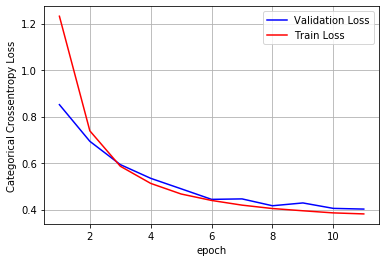

In [50]:
#plotting Loss vs Epochs
print('Test loss:', result[0])
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,12))
vy = history_2.history['val_loss']
ty = history_2.history['loss']
plt_dynamic(x, vy, ty, ax)

<h4>Plot : Train AUC vs Epochs

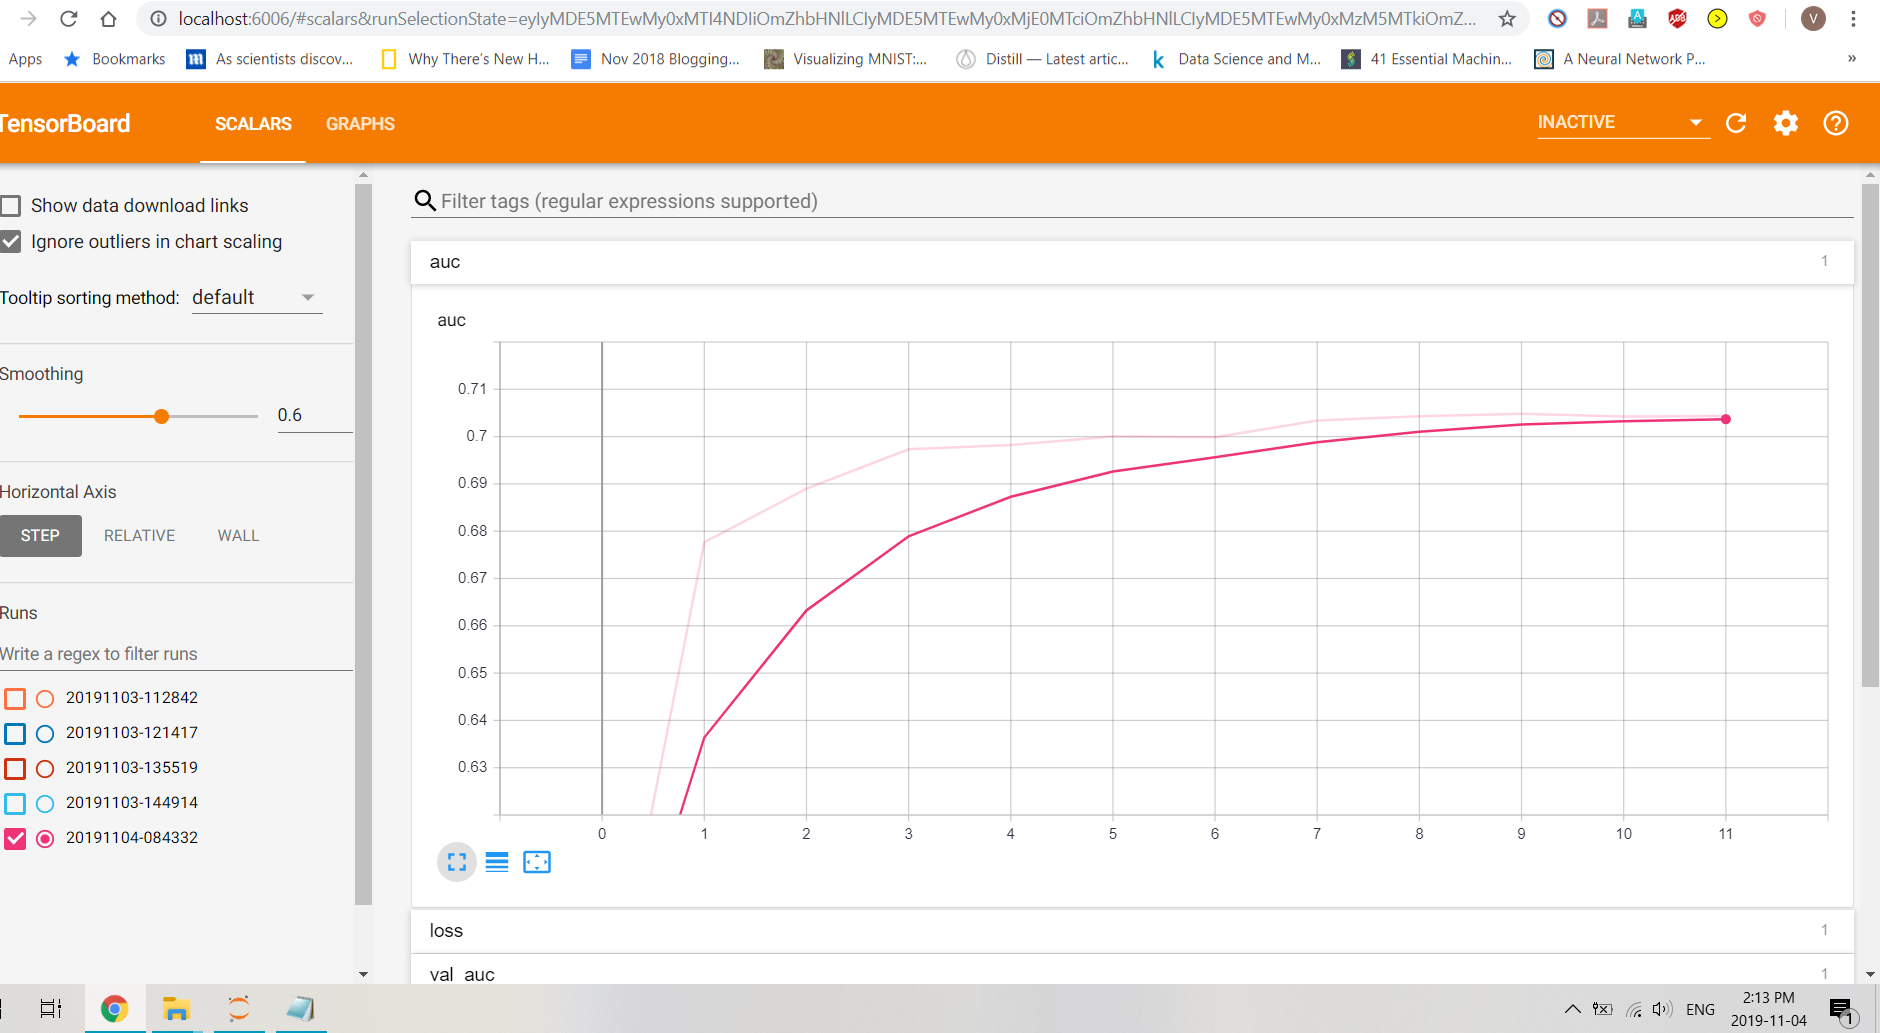

In [14]:
Image(filename='img/model_2_auc.png', width=500, height=500)

<h4>Plot : Test AUC vs Epochs

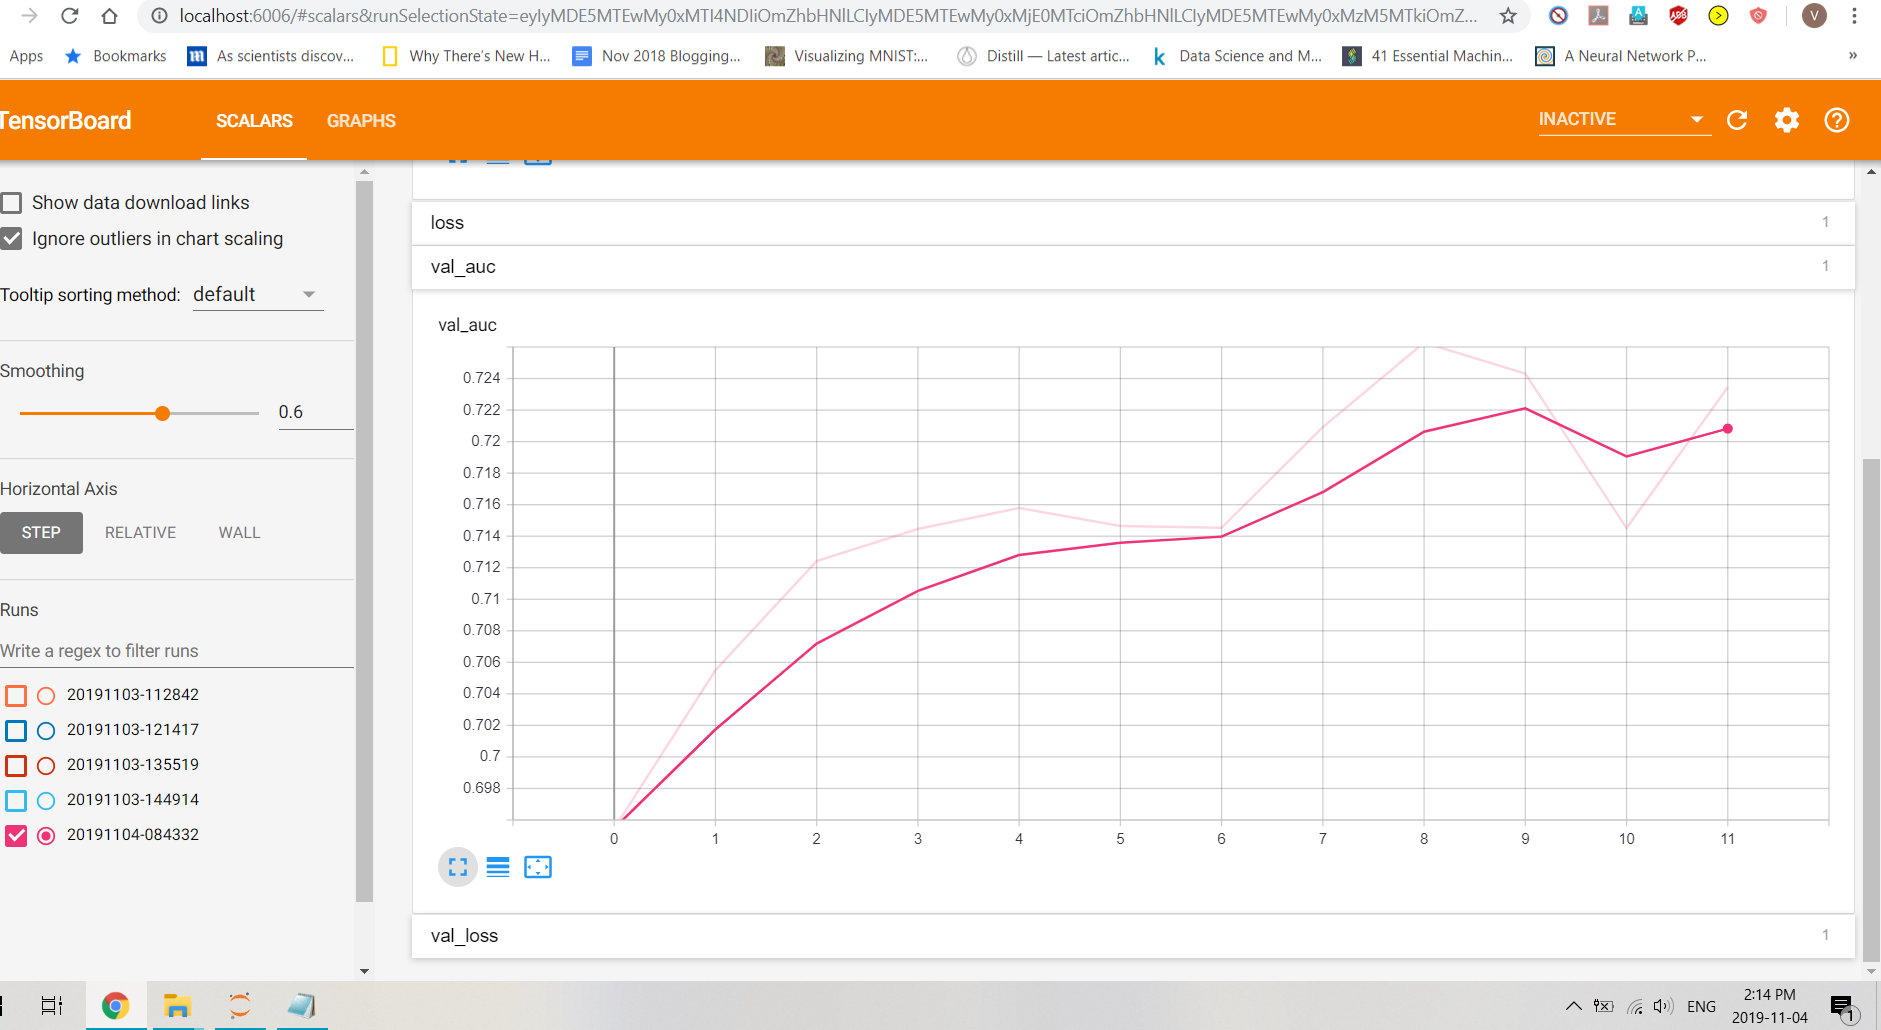

In [15]:
Image(filename='img/model_2_val_auc.png', width=500, height=500)

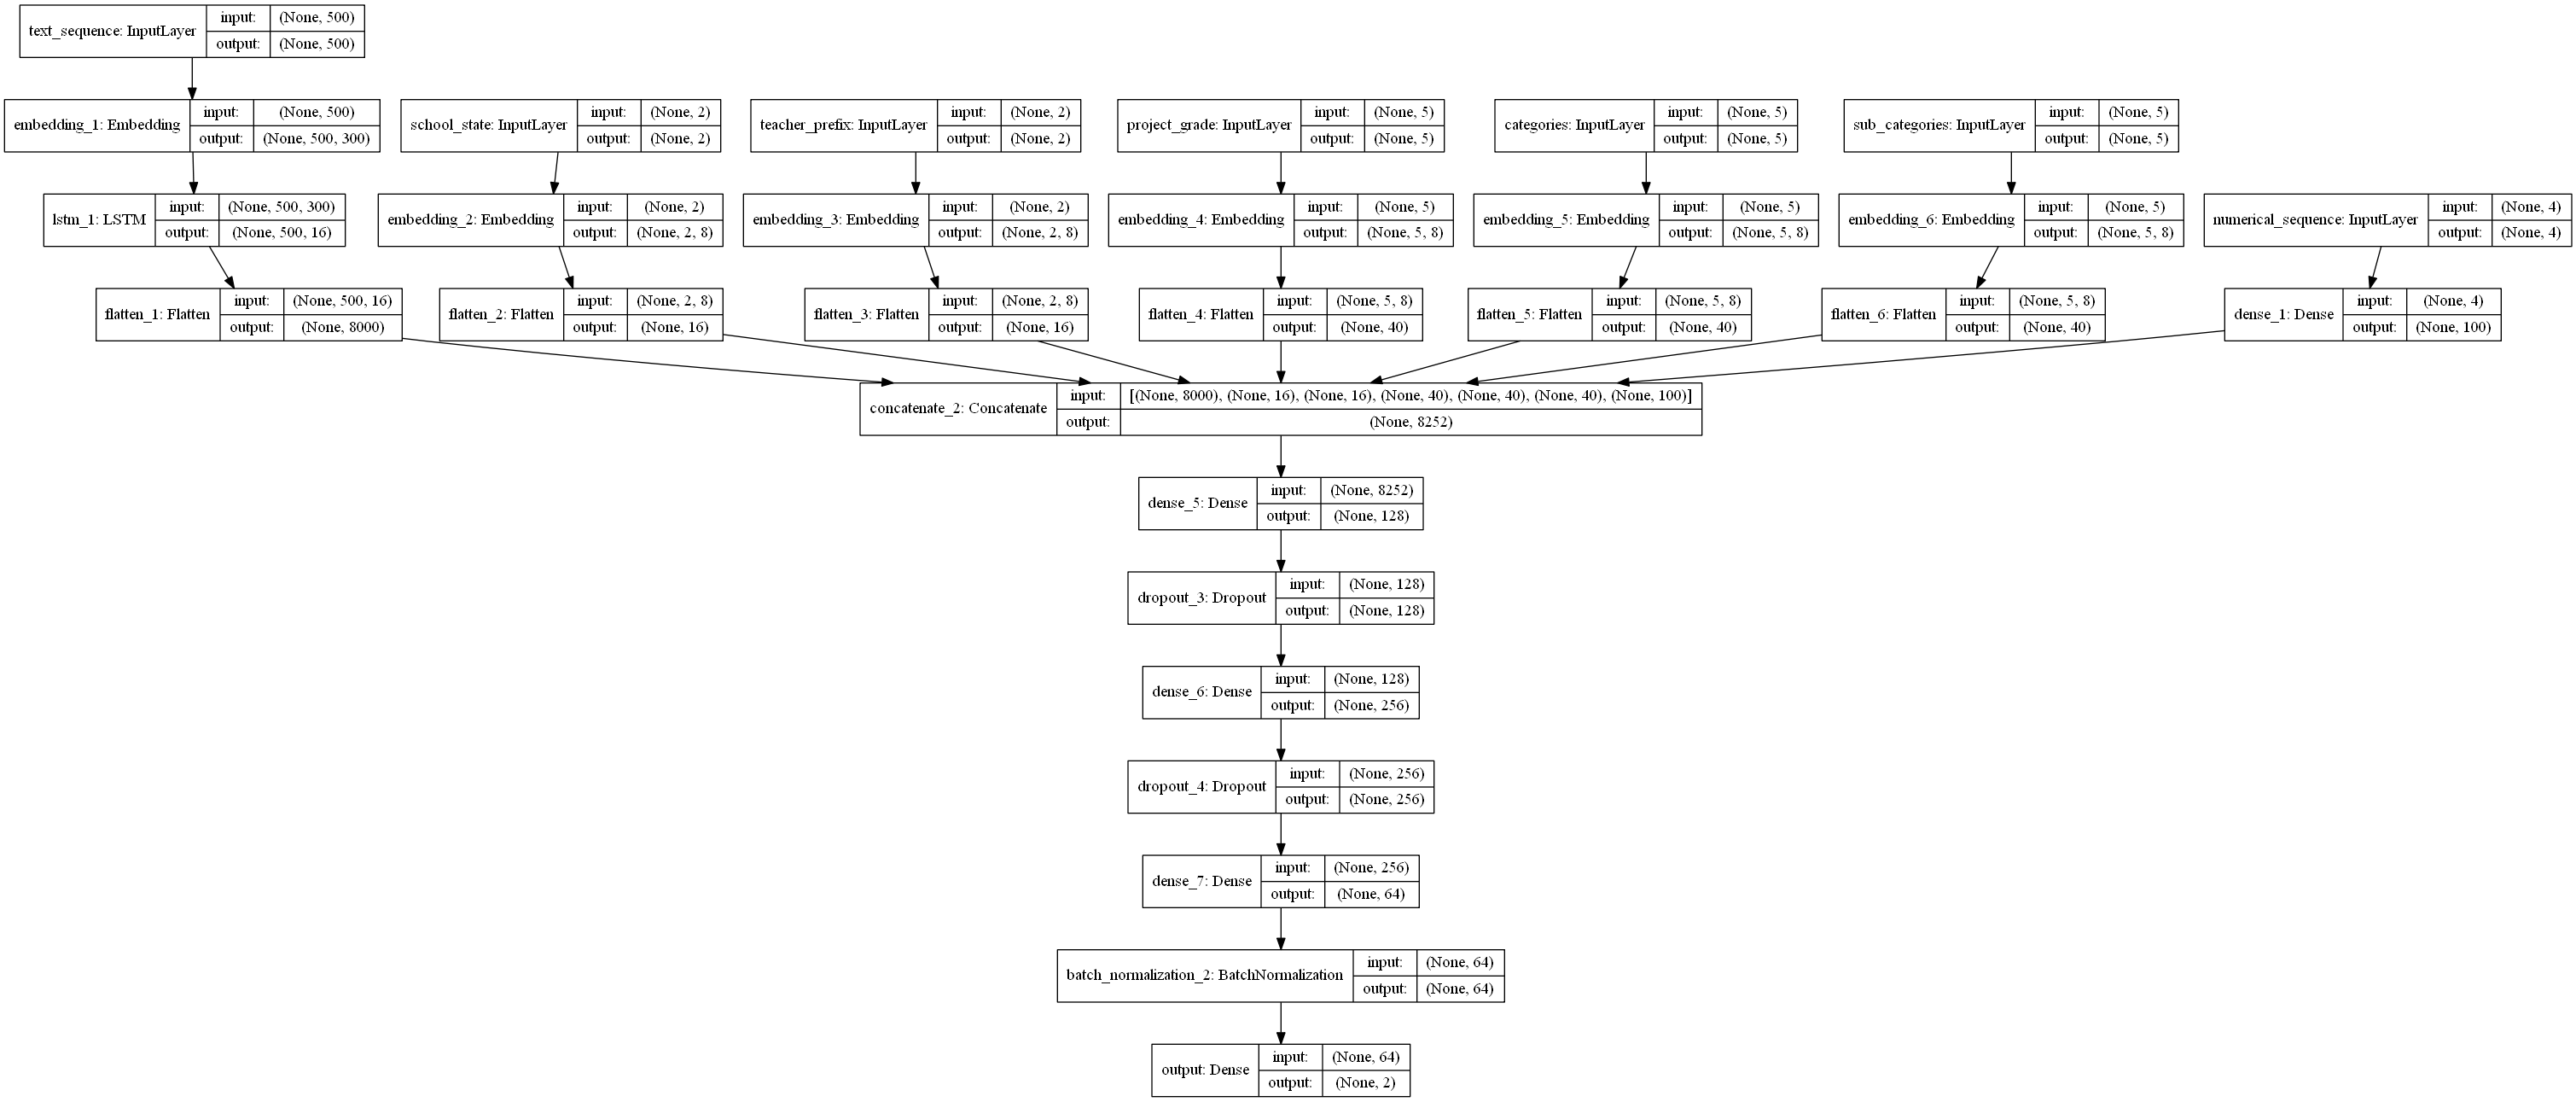

In [51]:
#displaying the model
from keras.utils.vis_utils import plot_model
plot_model(model_2, to_file='model_2.png', show_shapes=True, show_layer_names=True)

<h2>Assignment-3

<h3>Vectorizing text data

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['text'].values)
vocab_size = len(tokenizer.word_index) + 1
text_train = tokenizer.texts_to_sequences(x_train['text'].values)
text_test = tokenizer.texts_to_sequences(x_test['text'].values)

print(len(text_train))
print(text_train[1])

76473
[2, 314, 599, 104, 2, 404, 1, 123, 56, 76, 914, 130, 3, 508, 149, 386, 1468, 3323, 16828, 2795, 1865, 90, 10, 1, 652, 1, 587, 430, 695, 31, 1219, 8, 21, 10, 113, 308, 1046, 276, 5386, 654, 53, 117, 10, 1332, 19, 149, 26, 127, 113, 2, 35, 36, 5386, 652, 1, 60, 315, 13, 4523, 19, 2077, 169, 36, 635, 407, 830, 2077, 953, 2505, 4523, 19, 2914, 5165, 2, 74, 97, 547, 652, 1, 1215, 1, 10, 2929, 21, 149, 1993, 4, 4932, 169, 79, 262, 4, 4523, 19, 1181, 39, 98, 60, 1070, 3712, 4523, 19, 2914, 6038, 87, 5211, 35, 119, 9]


In [11]:
max_length_1 = 500
x_text_train = sequence.pad_sequences(text_train, maxlen=max_length_1, padding='post')
x_text_test = sequence.pad_sequences(text_test, maxlen=max_length_1, padding='post')

print(len(x_text_train))
print(x_text_train[1])

76473
[    2   314   599   104     2   404     1   123    56    76   914   130
     3   508   149   386  1468  3323 16828  2795  1865    90    10     1
   652     1   587   430   695    31  1219     8    21    10   113   308
  1046   276  5386   654    53   117    10  1332    19   149    26   127
   113     2    35    36  5386   652     1    60   315    13  4523    19
  2077   169    36   635   407   830  2077   953  2505  4523    19  2914
  5165     2    74    97   547   652     1  1215     1    10  2929    21
   149  1993     4  4932   169    79   262     4  4523    19  1181    39
    98    60  1070  3712  4523    19  2914  6038    87  5211    35   119
     9     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0   

In [12]:
# weight matrix using glove vectors
with open("glove_vectors", "rb") as fp: # Unpickling
    glove_vectors = pickle.load(fp)
    
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(50980, 300)

<h3>Categorical features : One-hot encoding

In [13]:
vect = CountVectorizer()
x_state_train = vect.fit_transform(x_train["school_state"])
x_state_test= vect.transform(x_test["school_state"])

vect = CountVectorizer()
x_prefix_train = vect.fit_transform(x_train["teacher_prefix"])
x_prefix_test= vect.transform(x_test["teacher_prefix"])

vect = CountVectorizer()
x_grade_train = vect.fit_transform(x_train["project_grade_category"])
x_grade_test= vect.transform(x_test["project_grade_category"])

vect = CountVectorizer()
x_categories_train = vect.fit_transform(x_train["project_subject_categories"])
x_categories_test= vect.transform(x_test["project_subject_categories"])

vect = CountVectorizer()
x_subcategories_train = vect.fit_transform(x_train["project_subject_subcategories"])
x_subcategories_test= vect.transform(x_test["project_subject_subcategories"])

In [14]:
#x_cat_train = sparse.hstack([x_state_train,x_prefix_train,x_grade_train,x_categories_train,x_subcategories_train]).todense()
#x_cat_test = sparse.hstack([x_state_test,x_prefix_test,x_grade_test,x_categories_test,x_subcategories_test]).todense()

In [15]:
print(x_state_train.shape,x_prefix_train.shape,x_grade_train.shape,x_categories_train.shape,x_subcategories_train.shape)

(76473, 51) (76473, 5) (76473, 4) (76473, 50) (76473, 389)


<h3>Numerical features : Standardization

In [16]:
scaler = StandardScaler()
x_quantity_train = scaler.fit_transform(x_train['quantity'].values.reshape(-1,1))
x_quantity_test = scaler.transform(x_test['quantity'].values.reshape(-1,1))

scaler = StandardScaler()
x_price_train = scaler.fit_transform(x_train['price'].values.reshape(-1,1))
x_price_test = scaler.transform(x_test['price'].values.reshape(-1,1))

scaler = StandardScaler()
x_no_projects_train = scaler.fit_transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_no_projects_test = scaler.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

scaler = StandardScaler()
x_summary_numerical_train = scaler.fit_transform(x_train['summary_numerical'].values.reshape(-1,1))
x_summary_numerical_test = scaler.transform(x_test['summary_numerical'].values.reshape(-1,1))

#x_numerical_train = np.concatenate((x_quantity_train,x_price_train,x_no_projects_train,x_summary_numerical_train), axis=1)
#x_numerical_test = np.concatenate((x_quantity_test,x_price_test,x_no_projects_test,x_summary_numerical_test), axis=1)

In [17]:
print(x_quantity_train.shape,x_price_train.shape,x_no_projects_train.shape,x_summary_numerical_train.shape)
#print(x_numerical_train.shape)

(76473, 1) (76473, 1) (76473, 1) (76473, 1)


In [18]:
x_train_data = sparse.hstack([x_state_train,x_prefix_train,x_grade_train,x_categories_train,x_subcategories_train,x_quantity_train,x_price_train,x_no_projects_train,x_summary_numerical_train]).toarray()
x_test_data = sparse.hstack([x_state_test,x_prefix_test,x_grade_test,x_categories_test,x_subcategories_test,x_quantity_test,x_price_test,x_no_projects_test,x_summary_numerical_test]).toarray()

Reference :https://stackoverflow.com/questions/48140989/keras-lstm-input-dimension-setting

In [19]:
x_train_data = np.expand_dims(x_train_data, 2)
x_test_data = np.expand_dims(x_test_data, 2)

In [20]:
x_train_data.shape

(76473, 503, 1)

In [21]:
y_train = keras.utils.to_categorical(y_train,num_classes= 2)
y_test = keras.utils.to_categorical(y_test,num_classes= 2)

<h3>Model-3

In [22]:
tf.keras.backend.clear_session()

In [23]:
input_text = Input(shape=(500,), dtype='int32', name = "text_sequence")
embedding_text = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix],input_length=max_length_1, \
                           trainable=False)(input_text)
lstm_text  = LSTM(16, activation="relu", return_sequences=True)(embedding_text)
flatten_text = Flatten()(lstm_text)

Instructions for updating:
Colocations handled automatically by placer.


In [24]:
input_others =  Input(shape=(503,1),name='other_features')
conv_1 = Conv1D(filters=128, kernel_size=3, activation='relu',kernel_initializer="he_normal")(input_others)
conv_2 = Conv1D(filters=128, kernel_size=3, activation='relu',kernel_initializer="he_normal")(conv_1)
flatten_others = Flatten()(conv_2)

In [25]:
x = concatenate([flatten_text,flatten_others])
x = Dense(128,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(256,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
output = Dense(2, activation='softmax', name='output')(x)
model_3 = Model(inputs=[input_text,input_others],outputs=[output])

model_3.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[auc])
model_3.summary()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_sequence (InputLayer)      (None, 500)          0                                            
__________________________________________________________________________________________________
other_features (InputLayer)     (None, 503, 1)       0                                            
______________________________________________________

In [26]:
checkpoint_3 = keras.callbacks.ModelCheckpoint('model_3.hdf5', save_best_only= True, monitor='val_auc', mode = 'max', verbose= 1)
early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', mode= 'max', verbose=1, patience=3)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=0)

In [27]:
train_model_3 = [x_text_train,x_train_data]
test_model_3 = [x_text_test,x_test_data]

In [28]:
history_3 = model_3.fit(train_model_3,y_train,batch_size=512,epochs=15,verbose=2,validation_data=(test_model_3,y_test),\
                        callbacks=[checkpoint_3,early_stop,tensorboard_callback])

Instructions for updating:
Use tf.cast instead.
Train on 76473 samples, validate on 32775 samples
Epoch 1/15
 - 844s - loss: 1.0465 - auc: 0.5676 - val_loss: 0.7017 - val_auc: 0.6955

Epoch 00001: val_auc improved from -inf to 0.69547, saving model to model_3.hdf5
Epoch 2/15
 - 776s - loss: 0.6093 - auc: 0.6777 - val_loss: 0.5783 - val_auc: 0.7055

Epoch 00002: val_auc improved from 0.69547 to 0.70551, saving model to model_3.hdf5
Epoch 3/15
 - 825s - loss: 0.5070 - auc: 0.6890 - val_loss: 0.5155 - val_auc: 0.7124

Epoch 00003: val_auc improved from 0.70551 to 0.71242, saving model to model_3.hdf5
Epoch 4/15
 - 783s - loss: 0.4627 - auc: 0.6973 - val_loss: 0.4850 - val_auc: 0.7145

Epoch 00004: val_auc improved from 0.71242 to 0.71446, saving model to model_3.hdf5
Epoch 5/15
 - 821s - loss: 0.4394 - auc: 0.6982 - val_loss: 0.4452 - val_auc: 0.7158

Epoch 00005: val_auc improved from 0.71446 to 0.71578, saving model to model_3.hdf5
Epoch 6/15
 - 935s - loss: 0.4264 - auc: 0.7000 - val_l

In [29]:
best_model = load_model('model_3.hdf5', custom_objects={'auc': auc}) #retrieving best model

In [30]:
result = best_model.evaluate(test_model_3, y_test,batch_size=512)#evaluating test data

32775/32775 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 56 - ETA: 55 - ETA: 53 - ETA: 52 - ETA: 50 - ETA: 48 - ETA: 47 - ETA: 45 - ETA: 43 - ETA: 42 - ETA: 40 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 34 - ETA: 33 - ETA: 31 - ETA: 30 - ETA: 28 - ETA: 26 - ETA: 25 - ETA: 23 - ETA: 21 - ETA: 20 - ETA: 18 - ETA: 16 - ETA: 14 - ETA: 13 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 107s 3ms/step


<h4>Plot: Train AUC vs Epochs

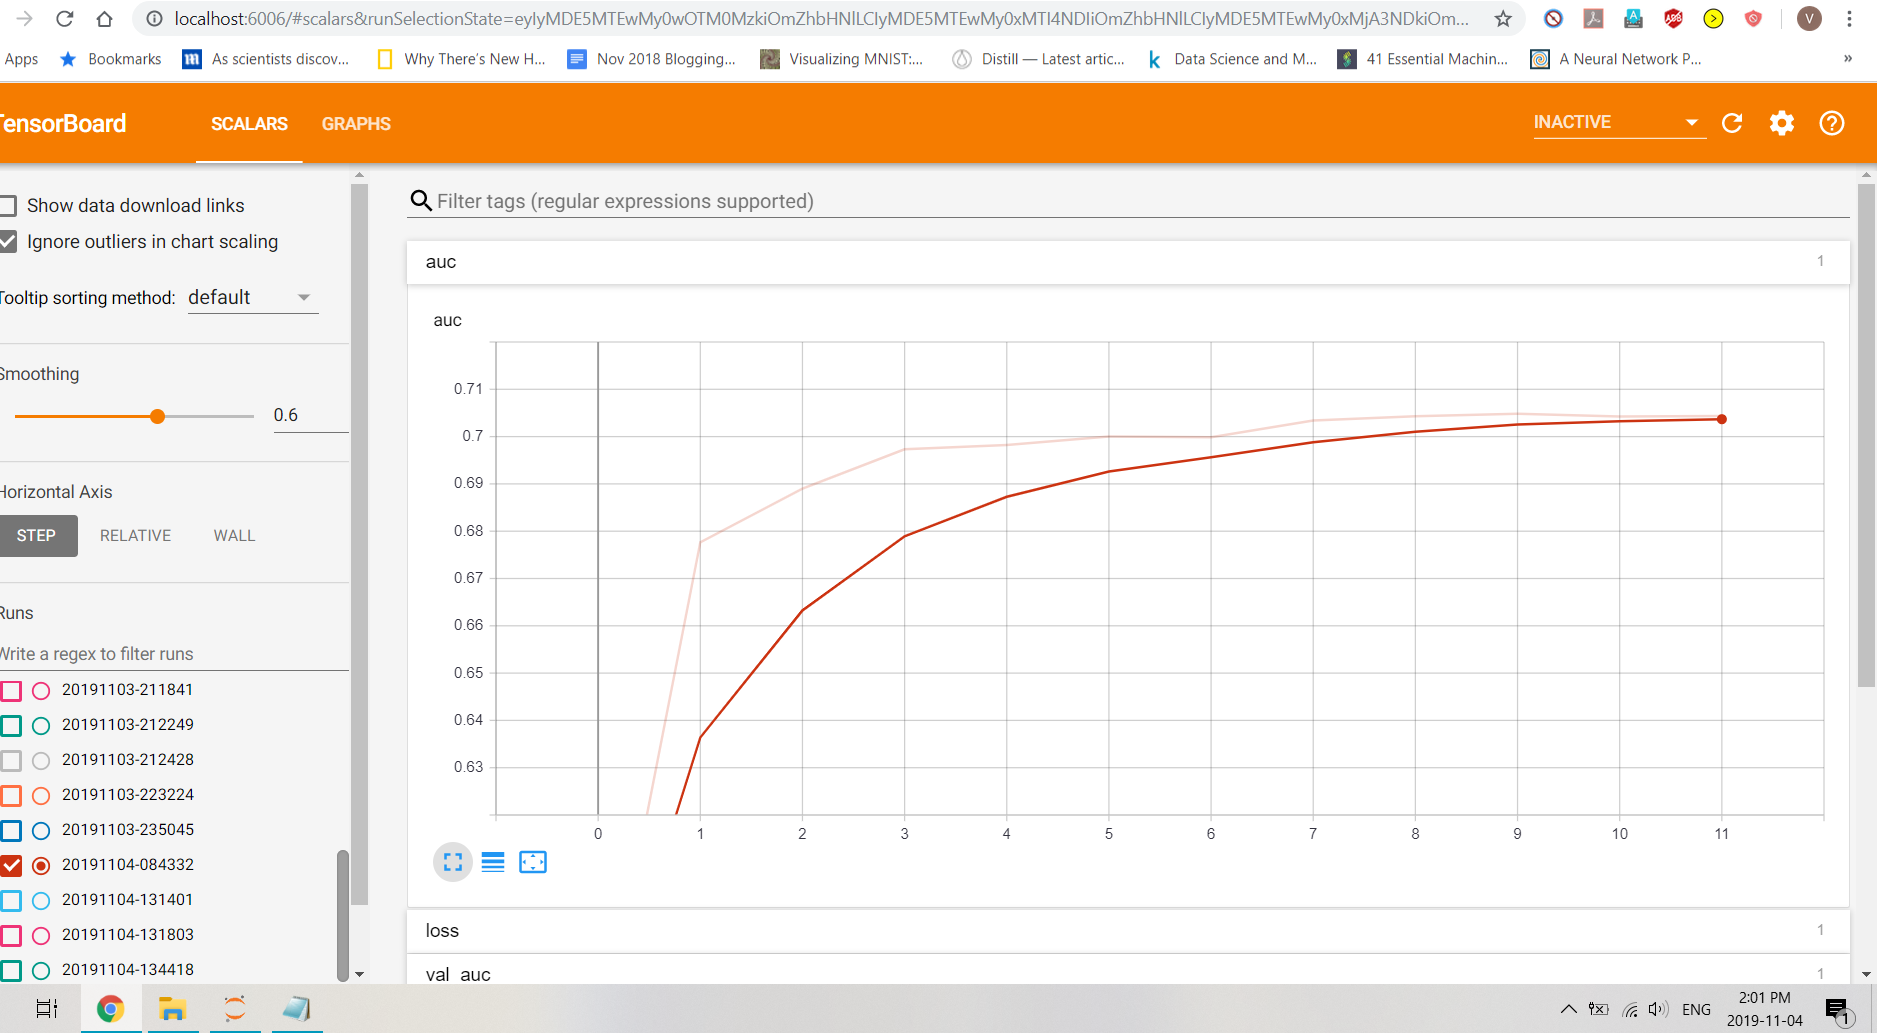

In [16]:
Image(filename='img/model_3_auc.png', width=500, height=500)

<h4>Plot : Test AUC vs Epochs

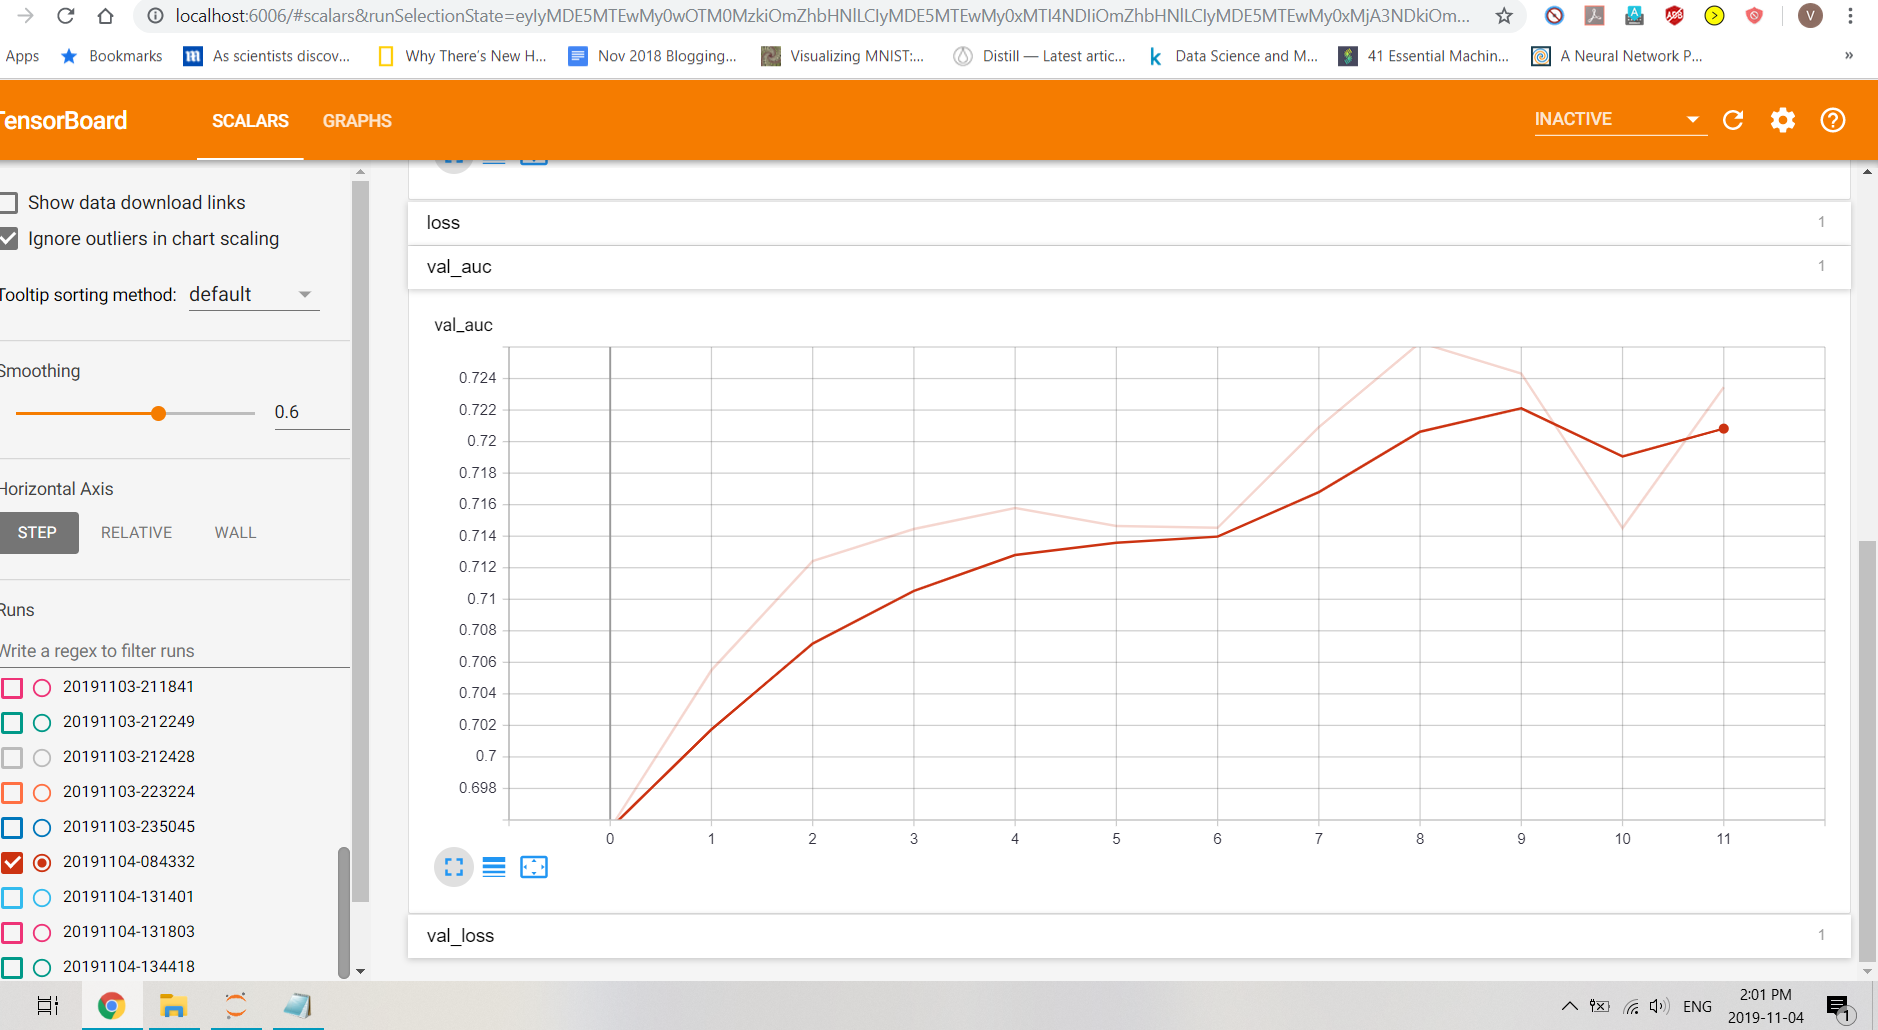

In [17]:
Image(filename='img/model_3_val_auc.png', width=500, height=500)

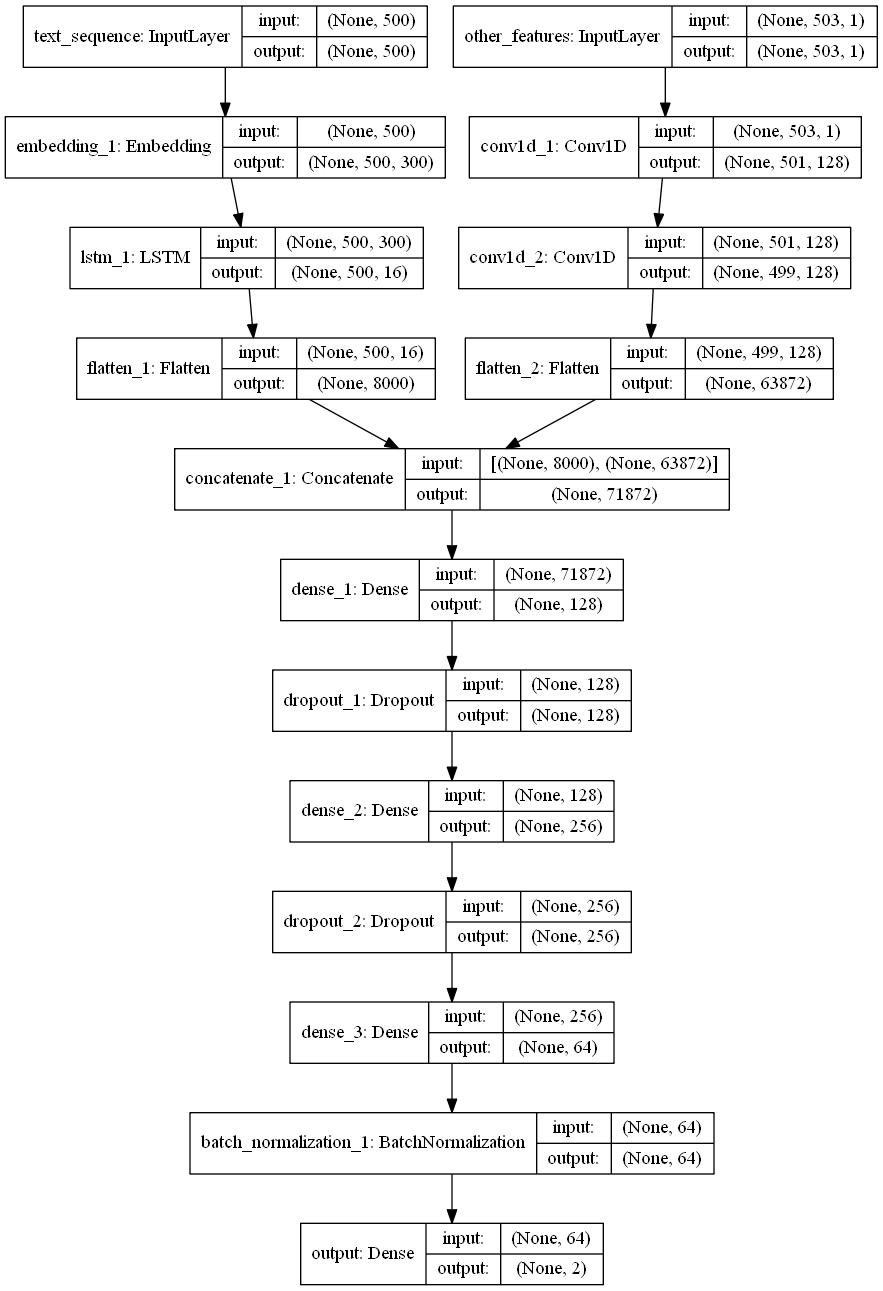

In [37]:
#displaying the model
from keras.utils.vis_utils import plot_model
plot_model(model_3, to_file='model_3.png', show_shapes=True, show_layer_names=True)

<h3>Pretty Table

In [40]:
from prettytable import PrettyTable
x = PrettyTable()
columns = ['Models','Train AUC','Test AUC']
x.add_column(columns[0],['Model-1[LSTM]','Model-2[LSTM with TF-IDF]','Model-3[LSTM with Conv1D]'])
x.add_column(columns[1],[0.7739,0.7762,0.7043])
x.add_column(columns[2],[0.7726,0.7562,0.7263])
print(x)

+---------------------------+-----------+----------+
|           Models          | Train AUC | Test AUC |
+---------------------------+-----------+----------+
|       Model-1[LSTM]       |   0.7739  |  0.7726  |
| Model-2[LSTM with TF-IDF] |   0.7762  |  0.7562  |
| Model-3[LSTM with Conv1D] |   0.7043  |  0.7263  |
+---------------------------+-----------+----------+


Conclusion: 

1.By monitoring the epochs, we can conclude that the model-1 with simple LSTM converged fast with high AUC compared to other models.

2.With the addition of dropouts, over-fitting has been avoided in the LSTM models.

3.Addition of TFIDF-vectorization of the text data didn't provide any significant improvement to the model's AUC.

<pre>
1. Download the preprocessed DonorsChoose data from here <a href='https://drive.google.com/file/d/1GU3LIJJ3zS1xLXXe-sdItSJHtI5txjVO/view?usp=sharing'>Dataset</a>
2. Split the data into train, cv, and test
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric. you need to print the AUC value for each epoch. Note: you should NOT use the tf.metric.auc
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. You should Save the best model weights.
8. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
9. Use Categorical Cross Entropy as Loss to minimize.
10. try to get AUC more than 0.8 for atleast one model
</pre>

### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

### Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data feature 'essay' <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>